In [12]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.graph_objects as go
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
# method 1 : use beauty module

from beauty import Beauty
beauty = Beauty('http://pc-tbed-bst-prod:8080')
#beauty = Beauty('https://vm-atlas-tdaq-cc.cern.ch/tbed/pbeast/api/')  //P1 online data

In [14]:
run_num = 479269

In [15]:
csv_path = '/eos/home-i03/m/mdtoffline/mdt_dcs_offline/run_files/'

run_num_list = pd.read_csv(csv_path + 'run_numbs_start_end.csv')  # load existing csv

In [16]:
ts_start_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_start'].values[0]
ts_end_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_end'].values[0]

fmt = '%Y-%m-%d %H:%M:%S'

since_dt = dt.strptime(ts_start_dt, fmt) - timedelta(minutes=10)
till_dt = dt.strptime(ts_end_dt, fmt) + timedelta(minutes=10)
print(since_dt)
print(till_dt)

2024-06-30 04:22:00
2024-06-30 19:27:42


In [17]:
# since = dt(2024, 4, 18, 18, 20, 0) # Scan for a stable beam run
# till = dt(2024, 4, 19, 8, 20, 0)
# since

In [18]:
lbn = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqLumiBlockNumber.value',None, False)[0]
int(dt.timestamp(lbn.index[0])*1e6)

1719713551503000

In [19]:
def query_data(query, source = 'DCS', type = 'number'):
    queryData = db.get_data('DCS', f'ATLAS_PVSS{source}', f'value-{type}', f'.*{query}.*', True, since_ts, till_ts, 0, True)
    df = queryDataToDataFrame(queryData)
    df.sort_values(by=['ts'], inplace=True)
    df['ts'] = pd.to_datetime(df['ts'], unit = 'us')
    
    return df

In [20]:
lbn_lib = query_data('ATLGCSDDC:daqLumiBlockNumber.value')
lbn_lib

NameError: name 'db' is not defined

In [16]:
# test stable beam flag
sbFlag = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value',None, False)[0]
sb_start_dt = sbFlag.index[0].replace(tzinfo=None)
sb_end_dt = sbFlag.index[1].replace(tzinfo=None)
sbFlag

2024-06-30 04:28:25.043000+02:00    1.0
2024-06-30 19:12:10.371000+02:00    0.0
Name: ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value, dtype: float64

In [17]:
# test stable beam flag
beam_type_Flag = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSLHC:DetectorBIS.BeamStateFlags',None, False)[0]

beam_type_Flag

2024-06-30 04:28:25.972000+02:00    1.0
2024-06-30 19:12:10.957000+02:00    0.0
Name: ATLGCSLHC:DetectorBIS.BeamStateFlags, dtype: float64

In [18]:
sb_range = str(sb_start_dt)[:-3] + ' - ' + str(sb_end_dt)[:-3]
sb_range

'2024-06-30 04:28:25.043 - 2024-06-30 19:12:10.371'

In [19]:
r4pFlag = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSLHC:ATLAS.Ready4Physics',None, False)[0]
r4p_start_dt = r4pFlag.index[0].replace(tzinfo=None)
r4p_end_dt = r4pFlag.index[1].replace(tzinfo=None)
r4pFlag

2024-06-30 04:56:08.697000+02:00    1.0
2024-06-30 19:11:24.610000+02:00    0.0
Name: ATLGCSLHC:ATLAS.Ready4Physics, dtype: float64

In [20]:
rlinfo_arr = []

for lbi, lb in zip(lbn.index, lbn.values):

    lbi = lbi.replace(tzinfo=None)
    sb = 0
    r4p = 0
    
    if sb_start_dt < lbi < sb_end_dt:
        sb = 1
    if r4p_start_dt < lbi < r4p_end_dt:
        r4p = 1
    rlinfo = ({ 'LumiBlock': int(lb),'AtlasPhysics': r4p, 'StableBeams': sb, 'ts': lbi})
    rlinfo_arr.append(rlinfo)

rlinfo_df = pd.DataFrame(rlinfo_arr)
rlinfo_df

LumiBlock  AtlasPhysics  StableBeams                         ts
0            34             0            0 2024-06-30 04:12:31.503000
1            34             0            0 2024-06-30 04:22:57.788001
2             0             0            1 2024-06-30 04:30:57.905000
3             1             0            1 2024-06-30 04:32:00.107000
4             2             0            1 2024-06-30 04:33:00.218000
...         ...           ...          ...                        ...
1084       1082             0            0 2024-06-30 19:14:12.597000
1085       1083             0            0 2024-06-30 19:15:12.600000
1086       1084             0            0 2024-06-30 19:16:12.710000
1087       1085             0            0 2024-06-30 19:17:12.717000
1088       1085             0            0 2024-06-30 19:22:52.997000

[1089 rows x 4 columns]

In [21]:
# since_dt = sbFlag.index[0].to_pydatetime().replace(tzinfo=None)  # Set start and end times for stable beam run
# till_dt = sbFlag.index[1].to_pydatetime().replace(tzinfo=None)
# since_dt

In [22]:
hltmon = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSMDT', 'value-number', 'ATLMDTPS2:CAEN/PSMDT02/branchController00/easyCrate0/easyBoard01/channel001.actual.iMon', None, False)[0]
lumi = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi.value', None, False)[0]
mu = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_Mu.value', None, False)[0]

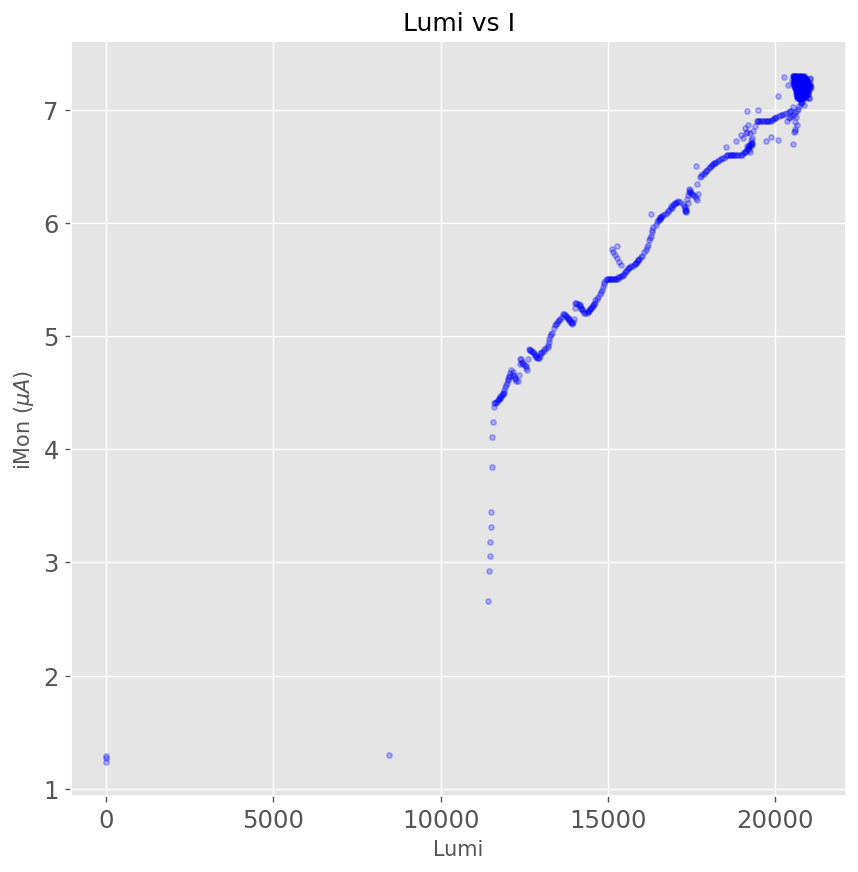

In [23]:
hv_lumi = hltmon.correlate(lumi)
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(8,8), dpi=125)

hv_lumi.plot(marker='.',linestyle='None',color='blue',alpha = .25)
plt.xlabel('Lumi')
plt.ylabel(r'iMon ($\mu A$)')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Lumi vs I')
plt.show()

In [4]:
# method 2 : use libpbeasepy module

import libpbeastpy

db = libpbeastpy.ServerProxy('http://pc-tbed-bst-prod:8080')

In [5]:
import re
import pandas as pd

#function to create the dataframe from queryData

def queryDataToDataFrame(queryData):
    
    # Define a regular expression pattern to match the timestamp and value
    pattern = r"DataPoint\(ts=(\d+), value=('.*?'|[0-9.]+)\)"

    row =[]
    
    for key in queryData[0].data.keys():
        for x in queryData[0].data[key]:
            #print(x)
            # Use re.match to find the values
            match = re.match(pattern, str(x))
            if match:
                timestamp = match.group(1)
                value = match.group(2)
                #print(f"Timestamp: {timestamp}, Value: {value}")
            else:
                print("The string does not match the expected format.")
                return
            row.append((key,timestamp,value))
    # Define column names
    column_names = ['datapoint','ts', 'value']

    # Create the DataFrame using the list of tuples
    df = pd.DataFrame(row, columns=column_names)
    return df

In [26]:
run_num = 479374

In [27]:
ts_start_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_start'].values[0]
ts_end_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_end'].values[0]

fmt = '%Y-%m-%d %H:%M:%S'

# ts_start_dt = "2024-08-31 02:09:25"
# ts_end_dt = "2024-08-31 18:21:09"

since_dt = dt.strptime(ts_start_dt, fmt)
till_dt = dt.strptime(ts_end_dt, fmt)
print(since_dt)
print(till_dt)
print(till_dt-since_dt)

2024-07-01 22:42:22
2024-07-02 15:31:10
16:48:48


In [28]:
since_ts = int(since_dt.timestamp()*1e6)
till_ts = int(till_dt.timestamp()*1e6)

In [29]:
def timestamp_to_pdSeries(df):
    t = pd.Series([],dtype='object')
    for i in df['ts'].astype('float64').values:
        _ = pd.Series([dt.fromtimestamp(i/1e6)])
        t = pd.concat([t,_])
    return t

In [30]:
def time_plot(tsys, since_dt, till_dt, title, ylabel, ybound = False, ybound_scale=.1):

    times = pd.date_range(since_dt, till_dt, periods=7)
    max_ys = []
    min_ys = []
    
    fig, ax = plt.subplots(1,figsize=(9,5),dpi=125)
    fig.autofmt_xdate()
    xfmt = dates.DateFormatter(fmt[:8] + '\n' + fmt[9:])
    ax.xaxis.set_major_formatter(xfmt)
    for t, y, l in tsys:
        max_ys.append(max(y))
        min_ys.append(min(y))
        ax.plot_date(t, y, '.-', mec='b', ms=2, label = l)
    if ybound == True:
        max_y = max(max_ys)
        min_y = min(min_ys)
        ax.set(ylim=(min_y*(1-ybound_scale), max_y*(1+ybound_scale)))
    plt.legend()
    plt.xticks(times)
    plt.title(title)
    plt.xlabel('t')
    plt.ylabel(ylabel)
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax.xaxis.grid(True, which="minor")
    plt.tight_layout()

In [31]:
%%time
mdt_hvImon_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', 'ATLMDTPS2:CAEN/PSMDT02/branchController00/easyCrate0/easyBoard01/channel001.actual.iMon', True, since_ts, till_ts, 0, True)

CPU times: user 2.72 ms, sys: 6.64 ms, total: 9.36 ms
Wall time: 339 ms


In [32]:
md_hvImon_df = queryDataToDataFrame(mdt_hvImon_queryData)

In [33]:
md_hvImon_df.sort_values(by=['ts'], inplace=True)

In [34]:
t = pd.to_datetime(md_hvImon_df['ts'], unit = 'us')
y = md_hvImon_df['value'].astype('float64')

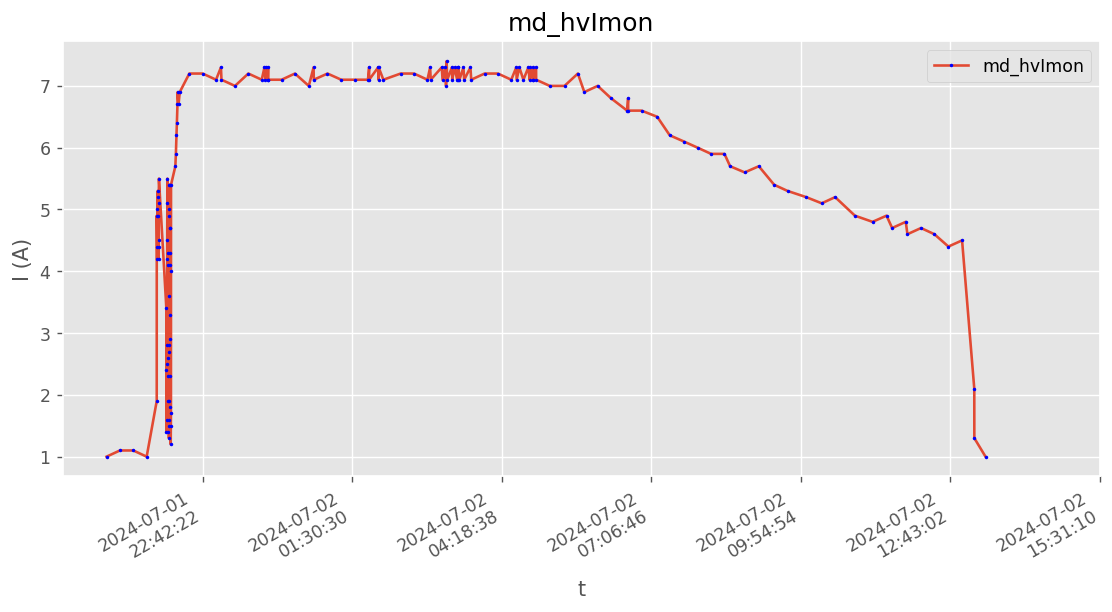

In [35]:
time_plot([(t, y, 'md_hvImon')], since_dt, till_dt, 'md_hvImon', 'I (A)')
plt.show()

In [36]:
%%time
mdt_hvVmon_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', 'ATLMDTPS2:CAEN/PSMDT02/branchController00/easyCrate0/easyBoard01/channel001.actual.vMon', True, since_ts, till_ts, 0, True)

CPU times: user 2.67 ms, sys: 5.76 ms, total: 8.43 ms
Wall time: 314 ms


In [37]:
md_hvVmon_df = queryDataToDataFrame(mdt_hvVmon_queryData)

In [38]:
md_hvVmon_df.sort_values(by=['ts'], inplace=True)

In [39]:
t = pd.to_datetime(md_hvVmon_df['ts'], unit = 'us')
y = md_hvVmon_df['value'].astype('float64')

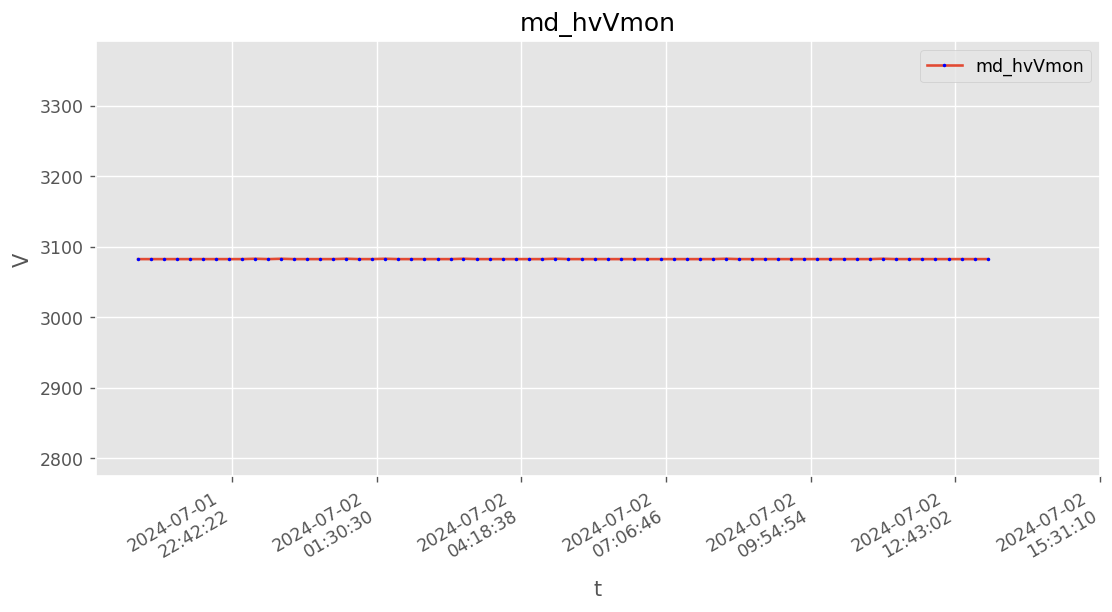

In [40]:
time_plot([(t, y, 'md_hvVmon')], since_dt, till_dt, 'md_hvVmon', 'V', True)
plt.show()

In [41]:
ts_start_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_start'].values[0]
ts_end_dt = run_num_list[run_num_list['run_number'] == run_num]['ts_end'].values[0]

ts_start_dt = '2024-07-01 09:13:57'
ts_end_dt = '2024-08-02 00:10:13'

fmt = '%Y-%m-%d %H:%M:%S'

since_dt = dt.strptime(ts_start_dt, fmt)
till_dt = dt.strptime(ts_end_dt, fmt)
print(since_dt)
print(till_dt)
print(till_dt-since_dt)
since_ts = int(since_dt.timestamp()*1e6)
till_ts = int(till_dt.timestamp()*1e6)

ts_start_dt_series = pd.to_datetime(run_num_list['ts_start'], format = fmt)
ts_end_dt_series = pd.to_datetime(run_num_list['ts_end'], format = fmt)


runs_in_timerange = run_num_list[(since_dt <= ts_start_dt_series ) & (till_dt >= ts_end_dt_series)]['run_number'].values
print(runs_in_timerange.shape[0])
runs_in_timerange

2024-07-01 09:13:57
2024-08-02 00:10:13
31 days, 14:56:16
12


array([479345, 479374, 479398, 479404, 479439, 479449, 479483, 479496,
       479507, 479519, 479553, 479563])

In [42]:
pd.set_option('display.max_colwidth', None)

mdt_unplugged_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*unplugged', True, since_ts, till_ts, 0, True)
mdt_unplugged_df = queryDataToDataFrame(mdt_unplugged_queryData)
mdt_unplugged_df = mdt_unplugged_df[mdt_unplugged_df['value'] != '0.0']
print(mdt_unplugged_df)

                                                                                          datapoint  \
95517  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel000.actual.unplugged   
95632  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel001.actual.unplugged   
95747  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel002.actual.unplugged   
95814  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel003.actual.unplugged   
95816  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel004.actual.unplugged   
95866  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel005.actual.unplugged   
95981  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel006.actual.unplugged   
96096  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/channel007.actual.unplugged   
96163  ATLMDTPS3:CAEN/PSMDT01/branchController15/easyCrate5/easyBoard13/c

In [43]:
%%time
# mdt_BIS7A_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BI.*A.*.Vcc', True, since_ts, till_ts, 0, True)
mdt_BIS7A12_VCC_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIS7A12.*.Vcc', True, since_ts, till_ts, 0, True)
md_hvVmon_df.sort_values(by=['ts'], inplace=True)

CPU times: user 7.69 ms, sys: 7.5 ms, total: 15.2 ms
Wall time: 743 ms


In [44]:
# mdt_BIS7A12_VCC = queryDataToDataFrame(mdt_BIS7A12_VCC_df)

In [45]:
# mdt_BIS7A12_VCC.sort_values(by=['ts'], inplace=True)

In [46]:
# mdt_BIS7A12_VCC.head(3)

In [47]:
# t = pd.to_datetime(mdt_BIS7A12_VCC['ts'], unit = 'us')
# y = mdt_BIS7A12_VCC['value'].astype('float64')

In [48]:
# time_plot([(t, y, 'mdt_BIS7A12_VCC')], since_dt, till_dt, 'mdt_BIS7A12_VCC', 'V', True)
# plt.show()

In [49]:
%%time
# mdt_BIS7A_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BI.*A.*.Vcc', True, since_ts, till_ts, 0, True)
mdt_BIL3A01_ntc01_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIL3A01.*.ntc.ntc01.*', True, since_ts, till_ts, 0, True)
mdt_BIL3A01_ntc02_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIL3A01.*.ntc.ntc02.*', True, since_ts, till_ts, 0, True)
mdt_BIL3A01_ntc03_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIL3A01.*.ntc.ntc03.*', True, since_ts, till_ts, 0, True)
mdt_BIL3A01_ntc04_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIL3A01.*.ntc.ntc04.*', True, since_ts, till_ts, 0, True)
mdt_BIL3A01_ntc05_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*BIL3A01.*.ntc.ntc05.*', True, since_ts, till_ts, 0, True)

CPU times: user 19.4 ms, sys: 24 ms, total: 43.4 ms
Wall time: 4.09 s


In [50]:
mdt_BIL3A01_ntc01 = queryDataToDataFrame(mdt_BIL3A01_ntc01_df)
mdt_BIL3A01_ntc02 = queryDataToDataFrame(mdt_BIL3A01_ntc02_df)
mdt_BIL3A01_ntc03 = queryDataToDataFrame(mdt_BIL3A01_ntc03_df)
mdt_BIL3A01_ntc04 = queryDataToDataFrame(mdt_BIL3A01_ntc04_df)
mdt_BIL3A01_ntc05 = queryDataToDataFrame(mdt_BIL3A01_ntc05_df)

In [51]:
mdt_BIL3A01_ntc01.sort_values(by=['ts'], inplace=True)
mdt_BIL3A01_ntc02.sort_values(by=['ts'], inplace=True)
mdt_BIL3A01_ntc03.sort_values(by=['ts'], inplace=True)
mdt_BIL3A01_ntc04.sort_values(by=['ts'], inplace=True)
mdt_BIL3A01_ntc05.sort_values(by=['ts'], inplace=True)

In [52]:
mdt_BIL3A01_ntc01.head(3)

datapoint                ts   value
0  ATLMDTMDM1:BIL3A01.ntc.ntc01.value  1719822027560000  23.832
1  ATLMDTMDM1:BIL3A01.ntc.ntc01.value  1719829271088000  23.853
2  ATLMDTMDM1:BIL3A01.ntc.ntc01.value  1719836514875000  23.828

In [53]:
t1 = pd.to_datetime(mdt_BIL3A01_ntc01['ts'], unit = 'us')
y1 = mdt_BIL3A01_ntc01['value'].astype('float64')
l1 = 'ntc01'
t2 = pd.to_datetime(mdt_BIL3A01_ntc02['ts'], unit = 'us')
y2 = mdt_BIL3A01_ntc02['value'].astype('float64')
l2 = 'ntc02'
t3 = pd.to_datetime(mdt_BIL3A01_ntc03['ts'], unit = 'us')
y3 = mdt_BIL3A01_ntc03['value'].astype('float64')
l3 = 'ntc03'
t4 = pd.to_datetime(mdt_BIL3A01_ntc04['ts'], unit = 'us')
y4 = mdt_BIL3A01_ntc04['value'].astype('float64')
l4 = 'ntc04'
t5 = pd.to_datetime(mdt_BIL3A01_ntc05['ts'], unit = 'us')
y5 = mdt_BIL3A01_ntc05['value'].astype('float64')
l5 = 'ntc05'

tsys = [(t1, y1, l1), (t2, y2, l2), (t3, y3, l3), (t4, y4, l4), (t5, y5, l5)]

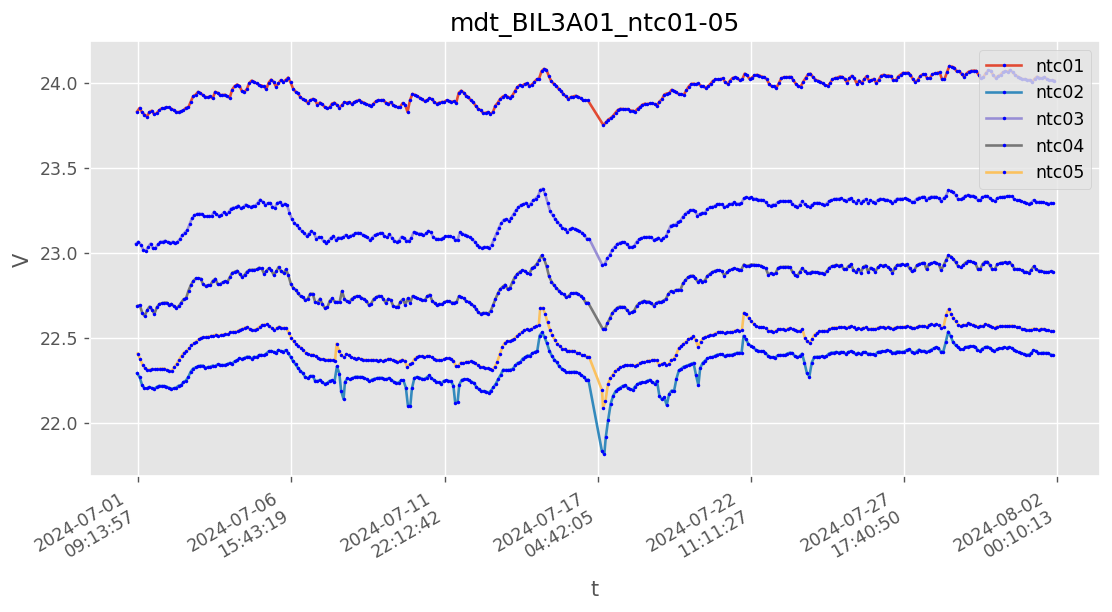

In [54]:
time_plot(tsys, since_dt, till_dt, 'mdt_BIL3A01_ntc01-05', 'V', True, .006)
plt.show()

In [226]:
# run_num = 473747
# run_num = 485431
run_num = 484653

rn = rn_df[rn_df['value'] == run_num]
print(rn)
ts_start_dt = rn_df['ts'].values[0]
ts_end_dt = rn_df['ts'].values[1]

# ts_start_dt = '2024-09-16 10:09:54'
# ts_end_dt = '2024-09-16 15:46:07'

# ts_start_dt = '2024-09-16 11:37:04' # Stable Beam
# ts_end_dt = '2024-09-16 12:28:31'

fmt = '%Y-%m-%d %H:%M:%S'

# since_dt = dt.strptime(ts_start_dt, fmt)
# till_dt = dt.strptime(ts_end_dt, fmt)

since_dt = ts_start_dt.astype(int)
till_dt = ts_end_dt.astype(int)

print(since_dt)
print(till_dt)
print(till_dt-since_dt)
since_ts = int(since_dt.timestamp()*1e6)
till_ts = int(till_dt.timestamp()*1e6)

       value                         dt                ts
1256  484653 2024-09-16 10:09:54.284000  1726481394284000
1257  484653 2024-09-16 15:46:07.654001  1726501567654001
1710335911222000
1710335911222001
1


AttributeError: 'numpy.int64' object has no attribute 'timestamp'

In [212]:
oldest = dt(2023,1,1,0,0)
now = dt.now()
rn_df = beauty.timeseries(oldest, now, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value',None, False)[0]
rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index.tz_localize(None)})
rn_df['value'] = rn_df['value'].astype(float).astype(int)
rn_df['ts'] = rn_df.dt.values.astype(int) // 10**3
rn_df

value                         dt                ts
0     470021 2024-03-13 13:18:31.222000  1710335911222000
1     470021 2024-03-13 13:18:31.222001  1710335911222001
2     470036 2024-03-13 13:24:19.286000  1710336259286000
3     470040 2024-03-13 13:36:24.876000  1710336984876000
4     470040 2024-03-13 17:22:57.652001  1710350577652001
...      ...                        ...               ...
1411  486110 2024-10-04 11:22:01.201000  1728040921201000
1412  486114 2024-10-04 11:29:41.816000  1728041381816000
1413  486114 2024-10-04 13:04:15.687001  1728047055687001
1414  486131 2024-10-04 13:26:06.306000  1728048366306000
1415  486131 2024-10-05 04:15:30.237000  1728101730237000

[1416 rows x 3 columns]

In [213]:
# run_num = 473747
# run_num = 485431
run_num = 484653

rn = rn_df[rn_df['value'] == run_num]

since_dt = rn['dt'].values[0]
till_dt = rn['dt'].values[1]

print(rn)

# ts_start_dt = '2024-09-16 10:09:54'
# ts_end_dt = '2024-09-16 15:46:07'

# ts_start_dt = '2024-09-16 11:37:04' # Stable Beam
# ts_end_dt = '2024-09-16 12:28:31'

fmt = '%Y-%m-%d %H:%M:%S'

# since_dt = dt.strptime(ts_start_dt, fmt)
# till_dt = dt.strptime(ts_end_dt, fmt)

# since_dt = ts_start_dt.astype(int)
# till_dt = ts_end_dt.astype(int)

print(since_dt, till_dt)
print(till_dt-since_dt)
since_ts = int(since_dt.astype(dt)/1e3)
till_ts = int(till_dt.astype(dt)/1e3)
print(since_ts, till_ts)

       value                         dt                ts
1256  484653 2024-09-16 10:09:54.284000  1726481394284000
1257  484653 2024-09-16 15:46:07.654001  1726501567654001
2024-09-16T10:09:54.284000000 2024-09-16T15:46:07.654001000
20173370001000 nanoseconds
1726481394284000 1726501567654001


In [214]:
# mdt_all_fsm_status_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-string', '.*fsm.currentState', True, int(sb_start_dt.timestamp()*1e6), int(sb_end_dt.timestamp()*1e6), 0, True)
# mdt_all_fsm_status_df = queryDataToDataFrame(mdt_all_fsm_status_queryData)
# mdt_all_fsm_status_df.sort_values(by=['ts'], inplace=True)
# print('All FSM values:\n\n', mdt_all_fsm_status_df['value'].unique())

In [215]:
mdt_fsm_status_queryData = db.get_data('DCS', 
                                       'ATLAS_PVSSMDT', 
                                       'value-string', 
                                       '.*_JTAG.*fsm.currentState|.*_ML1.*fsm.currentState|.*_ML2.*fsm.currentState|.*_LV.*fsm.currentState|', 
                                       True, 
                                       since_ts, 
                                       till_ts, 
                                       0, 
                                       True)

mdt_fsm_status_df = queryDataToDataFrame(mdt_fsm_status_queryData)

In [216]:
mdt_fsm_flags_df  = mdt_fsm_status_df[(mdt_fsm_status_df['value'] != "'OFF'") & 
                                      (mdt_fsm_status_df['value'] != "'ON'") & 
                                      (mdt_fsm_status_df['value'] != "'STANDBY'") & 
                                      (mdt_fsm_status_df['value'] != "'INITIALIZED'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMP_UP'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMPING'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMP_DOWN'") & 
                                      (mdt_fsm_status_df['value'] != "'REQUEST'") & 
                                      (mdt_fsm_status_df['value'] != "'PRELOAD'") & 
                                      (mdt_fsm_status_df['value'] != "'VERIFY'") & 
                                      (mdt_fsm_status_df['value'] != "'RESET'") & 
                                      (mdt_fsm_status_df['value'] != "'STRINGLOAD'") & 
                                      (mdt_fsm_status_df['value'] != "'READY'")
]

# mdt_fsm_flags_df  = mdt_fsm_status_df

mdt_fsm_flags_df.sort_values(by=['ts'], inplace=True, ignore_index = True)
mdt_fsm_flags_df['ts'] = pd.to_datetime(mdt_fsm_flags_df['ts'], unit = 'us')

In [217]:
mdt_fsm_flags_df

datapoint  \
0     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS5A06.fsm.currentState   
1     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS2A08.fsm.currentState   
2     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EML4A07.fsm.currentState   
3     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EML5A07.fsm.currentState   
4     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS3A06.fsm.currentState   
...                                                       ...   
2983   ATLMDTMDM2:MDT_BC_JTAG_MIDDLE|BML2C01.fsm.currentState   
2984    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL4C05.fsm.currentState   
2985    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL3C05.fsm.currentState   
2986    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL4C05.fsm.currentState   
2987    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL3C05.fsm.currentState   

                          ts              value  
0    2024-09-16 11:08:04.214  'NOT_INITIALIZED'  
1    2024-09-16 11:08:04.214  'NOT_INITIALIZED'  
2    2024-09-16 11:08:04.214  'NOT_INITIALIZED'  
3    2024-09-16 11:08:04.214  'NOT_INITIALIZED'  
4    2024-09-16 11:08:04.214  'NOT_INITIALIZED'  
...                      ...                ...  
2983 2024-09-16 12:53:23.032           'FAILED'  
2984 2024-09-16 13:36:39.278  'NOT_INITIALIZED'  
2985 2024-09-16 13:36:39.278  'NOT_INITIALIZED'  
2986 2024-09-16 13:36:57.481  'NOT_INITIALIZED'  
2987 2024-09-16 13:36:57.482  'NOT_INITIALIZED'  

[2988 rows x 3 columns]

In [218]:
mdt_fsm_flags_df['dt'] = pd.to_datetime(mdt_fsm_flags_df['ts'], unit = 'ms')
mdt_fsm_flags_df['ts'] = mdt_fsm_flags_df['dt'].astype(int)
mdt_fsm_flags_df['ts'] = mdt_fsm_flags_df['ts'].div(1e3).astype(int)

In [219]:
mdt_fsm_flags_df

datapoint  \
0     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS5A06.fsm.currentState   
1     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS2A08.fsm.currentState   
2     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EML4A07.fsm.currentState   
3     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EML5A07.fsm.currentState   
4     ATLMDTMDM4:MDT_ECA_JTAG_MIDDLE|EMS3A06.fsm.currentState   
...                                                       ...   
2983   ATLMDTMDM2:MDT_BC_JTAG_MIDDLE|BML2C01.fsm.currentState   
2984    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL4C05.fsm.currentState   
2985    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL3C05.fsm.currentState   
2986    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL4C05.fsm.currentState   
2987    ATLMDTMDM1:MDT_BC_JTAG_INNER|BIL3C05.fsm.currentState   

                    ts              value                      dt  
0     1726484884214000  'NOT_INITIALIZED' 2024-09-16 11:08:04.214  
1     1726484884214000  'NOT_INITIALIZED' 2024-09-16 11:08:04.214  
2     1726484884214000  'NOT_INITIALIZED' 2024-09-16 11:08:04.214  
3     1726484884214000  'NOT_INITIALIZED' 2024-09-16 11:08:04.214  
4     1726484884214000  'NOT_INITIALIZED' 2024-09-16 11:08:04.214  
...                ...                ...                     ...  
2983  1726491203032000           'FAILED' 2024-09-16 12:53:23.032  
2984  1726493799278000  'NOT_INITIALIZED' 2024-09-16 13:36:39.278  
2985  1726493799278000  'NOT_INITIALIZED' 2024-09-16 13:36:39.278  
2986  1726493817481000  'NOT_INITIALIZED' 2024-09-16 13:36:57.481  
2987  1726493817481999  'NOT_INITIALIZED' 2024-09-16 13:36:57.482  

[2988 rows x 4 columns]

In [220]:
mdt_fsm_flags_df[(mdt_fsm_flags_df.apply(lambda row: row.astype(str).str.contains('_ML1|_ML2').any(), axis=1))]

datapoint                ts  \
465   ATLMDTPS3:MDTPS_EA_OUTER|EOS2A14_ML2.fsm.currentState  1726485249425000   
466   ATLMDTPS3:MDTPS_EA_OUTER|EOS1A14_ML2.fsm.currentState  1726485249425000   
467   ATLMDTPS3:MDTPS_EA_OUTER|EOS4A14_ML1.fsm.currentState  1726485249425000   
468   ATLMDTPS3:MDTPS_EA_OUTER|EOL2A13_ML1.fsm.currentState  1726485249425000   
469   ATLMDTPS3:MDTPS_EA_OUTER|EOS1A14_ML1.fsm.currentState  1726485249425000   
...                                                     ...               ...   
2796  ATLMDTPS3:MDTPS_EA_OUTER|EOL2A05_ML2.fsm.currentState  1726490980712000   
2797  ATLMDTPS3:MDTPS_EA_OUTER|EOL6A05_ML2.fsm.currentState  1726490980712000   
2798  ATLMDTPS3:MDTPS_EA_OUTER|EOS1A06_ML2.fsm.currentState  1726490980712000   
2799  ATLMDTPS3:MDTPS_EA_OUTER|EOS6A08_ML2.fsm.currentState  1726490981134000   
2800  ATLMDTPS3:MDTPS_EA_OUTER|EOS5A08_ML2.fsm.currentState  1726490981134000   

            value                      dt  
465   'UNPLUGGED' 2024-09-16 11:14:09.425  
466   'UNPLUGGED' 2024-09-16 11:14:09.425  
467   'UNPLUGGED' 2024-09-16 11:14:09.425  
468   'UNPLUGGED' 2024-09-16 11:14:09.425  
469   'UNPLUGGED' 2024-09-16 11:14:09.425  
...           ...                     ...  
2796  'UNPLUGGED' 2024-09-16 12:49:40.712  
2797  'UNPLUGGED' 2024-09-16 12:49:40.712  
2798  'UNPLUGGED' 2024-09-16 12:49:40.712  
2799  'UNPLUGGED' 2024-09-16 12:49:41.134  
2800  'UNPLUGGED' 2024-09-16 12:49:41.134  

[1348 rows x 4 columns]

In [221]:
def generate_lbn_sb_r4p_df(since_dt, till_dt):
    
    lbn_df = beauty.timeseries(since_dt, 
                            till_dt, 
                            'DCS', 
                            'ATLAS_PVSSDCS', 
                            'value-number', 
                            'ATLGCSDDC:daqLumiBlockNumber.value', 
                            None, 
                            False)[0]
    sb_df = beauty.timeseries(since_dt, 
                               till_dt, 
                               'DCS', 
                               'ATLAS_PVSSDCS', 
                               'value-number', 
                               'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                               None, 
                               False)[0]
    r4p_df = beauty.timeseries(since_dt, 
                                till_dt, 
                                'DCS', 
                                'ATLAS_PVSSDCS', 
                                'value-number', 
                                'ATLGCSLHC:ATLAS.Ready4Physics', 
                                None, 
                                False)[0]
    
    lbn_df = pd.DataFrame({'value': lbn_df.array, 'dt': lbn_df.index.tz_localize(None)})
    sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index.tz_localize(None)})
    r4p_df = pd.DataFrame({'value': r4p_df.array , 'dt': r4p_df.index.tz_localize(None)})

    i = 0
    j = 0
    k = 0

    lbn = lbn_df.iloc[i]['value']
    sb = sb_df.iloc[j]['value']
    r4p = r4p_df.iloc[k]['value']

    lbn_ts = int(dt.timestamp(lbn_df.iloc[i]['dt'])*int(1e6))
    lbn_ts_prev = lbn_ts
    sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))    
    sb_ts_prev = lbn_ts
    r4p_ts = int(dt.timestamp(r4p_df.iloc[k]['dt'])*int(1e6))
    r4p_ts_prev = lbn_ts

    if sb_ts > lbn_ts:
    
        if sb == 1.0:
    
            sb = 0.0
    
        else:
    
            sb = 1.0
    
    if r4p_ts > lbn_ts:
    
        if r4p == 1.0:
    
            r4p = 0.0
    
        else:
    
            r4p = 1.0

    lbns = [lbn]
    lbn_tss = [lbn_ts]
    sbs = [sb]
    sb_tss = [sb_ts]
    r4ps = [r4p]
    r4p_tss= [r4p_ts]

    for i in range(1, lbn_df.shape[0]):
    
        lbn_ts = int(dt.timestamp(lbn_df.iloc[i]['dt'])*int(1e6))
        
        if lbn_ts_prev < sb_ts < lbn_ts:

            sb_ts_prev = sb_ts

            sb = sb_df.iloc[j]['value']

            j += 1

            if j < sb_df.shape[0]:

                sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))
    
        if lbn_ts_prev < r4p_ts < lbn_ts:

            r4p_ts_prev = r4p_ts
            
            r4p = r4p_df.iloc[k]['value']

            k += 1

            if k < r4p_df.shape[0]:
            
                r4p_ts = int(dt.timestamp(r4p_df.iloc[k]['dt'])*int(1e6))

        lbns.append(lbn_df.iloc[i]['value'])
        sbs.append(sb)
        r4ps.append(r4p)
        lbn_tss.append(lbn_ts_prev)
        sb_tss.append(sb_ts_prev)
        r4p_tss.append(r4p_ts_prev)
        
        lbn_ts_prev = lbn_ts
    
    dic_tmp = {'LumiBlock Number': lbns, 
               'StableBeam': sbs, 
               'Ready4Physics': r4ps, 
               'LumiBlock ts': lbn_tss, 
               'StableBeam ts': sb_tss, 
               'Ready4Physics ts': r4p_tss}
    
    lbn_sb_r4p_df = pd.DataFrame(dic_tmp)
    lbn_sb_r4p_df['LumiBlock dt'] = pd.to_datetime(lbn_sb_r4p_df['LumiBlock ts'], unit = 'us')
    #lbn_sb_r4p_df.drop(columns = ['Ready4Physics ts'], inplace = True)
    
    while lbn_sb_r4p_df['LumiBlock Number'].iloc[0] != 1.0:

        lbn_sb_r4p_df = lbn_sb_r4p_df.iloc[1:]

    return lbn_sb_r4p_df, sb_df

In [222]:
lbn_sb_r4p_df, sb_df = generate_lbn_sb_r4p_df(dt.fromtimestamp(since_ts/1e6), 
                                       dt.fromtimestamp(till_ts/1e6))

In [223]:
lbn_sb_r4p_df['StableBeam dt'] = pd.to_datetime(lbn_sb_r4p_df['StableBeam ts'], unit = 'us')
lbn_sb_r4p_df['Ready4Physics dt'] = pd.to_datetime(lbn_sb_r4p_df['Ready4Physics ts'], unit = 'us')

In [225]:
lbn_sb_r4p_df

LumiBlock Number  StableBeam  Ready4Physics      LumiBlock ts  \
34                1.0         0.0            0.0  1726494700838000   
35                2.0         0.0            0.0  1726494762542000   
36                3.0         0.0            0.0  1726494791690000   
37                4.0         0.0            0.0  1726494851890000   
38                5.0         0.0            0.0  1726494877934000   
..                ...         ...            ...               ...   
97               19.0         0.0            0.0  1726501304707000   
98               20.0         0.0            0.0  1726501364707000   
99               21.0         0.0            0.0  1726501424806000   
100              22.0         0.0            0.0  1726501468781000   
101              23.0         0.0            0.0  1726501528886000   

        StableBeam ts  Ready4Physics ts            LumiBlock dt  \
34   1726482511179000  1726482471273000 2024-09-16 13:51:40.838   
35   1726482511179000  1726482471273000 2024-09-16 13:52:42.542   
36   1726482511179000  1726482471273000 2024-09-16 13:53:11.690   
37   1726482511179000  1726482471273000 2024-09-16 13:54:11.890   
38   1726482511179000  1726482471273000 2024-09-16 13:54:37.934   
..                ...               ...                     ...   
97   1726482511179000  1726482471273000 2024-09-16 15:41:44.707   
98   1726482511179000  1726482471273000 2024-09-16 15:42:44.707   
99   1726482511179000  1726482471273000 2024-09-16 15:43:44.806   
100  1726482511179000  1726482471273000 2024-09-16 15:44:28.781   
101  1726482511179000  1726482471273000 2024-09-16 15:45:28.886   

              StableBeam dt        Ready4Physics dt  
34  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
35  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
36  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
37  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
38  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
..                      ...                     ...  
97  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
98  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
99  2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
100 2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  
101 2024-09-16 10:28:31.179 2024-09-16 10:27:51.273  

[68 rows x 9 columns]

In [199]:
test = pd.DataFrame(lbn_sb_r4p_df['StableBeam dt'].rename('Value'))
test

Value
34  2024-09-16 12:28:31.179
35  2024-09-16 12:28:31.179
36  2024-09-16 12:28:31.179
37  2024-09-16 12:28:31.179
38  2024-09-16 12:28:31.179
..                      ...
97  2024-09-16 12:28:31.179
98  2024-09-16 12:28:31.179
99  2024-09-16 12:28:31.179
100 2024-09-16 12:28:31.179
101 2024-09-16 12:28:31.179

[68 rows x 1 columns]

In [200]:
lbn_sb_r4p_df['LumiBlock Number'].max()

43.0

In [201]:
starter = 1
lbn_sb_r4p_df.iloc[-starter-20:-starter]


LumiBlock Number  StableBeam  Ready4Physics      LumiBlock ts  \
81                3.0         0.0            0.0  1726508251182000   
82                4.0         0.0            0.0  1726508261199000   
83                5.0         0.0            0.0  1726508271416000   
84                6.0         0.0            0.0  1726508281732000   
85                7.0         0.0            0.0  1726508291948000   
86                8.0         0.0            0.0  1726508302266000   
87                9.0         0.0            0.0  1726508321800000   
88               10.0         0.0            0.0  1726508332018000   
89               11.0         0.0            0.0  1726508342236000   
90               12.0         0.0            0.0  1726508383109000   
91               13.0         0.0            0.0  1726508393327000   
92               14.0         0.0            0.0  1726508403543000   
93               15.0         0.0            0.0  1726508413860000   
94               16.0         0.0            0.0  1726508424078000   
95               17.0         0.0            0.0  1726508434396000   
96               18.0         0.0            0.0  1726508494391000   
97               19.0         0.0            0.0  1726508504707000   
98               20.0         0.0            0.0  1726508564707000   
99               21.0         0.0            0.0  1726508624806000   
100              22.0         0.0            0.0  1726508668781000   

        StableBeam ts  Ready4Physics ts            LumiBlock dt  \
81   1726489711179000  1726489671273000 2024-09-16 17:37:31.182   
82   1726489711179000  1726489671273000 2024-09-16 17:37:41.199   
83   1726489711179000  1726489671273000 2024-09-16 17:37:51.416   
84   1726489711179000  1726489671273000 2024-09-16 17:38:01.732   
85   1726489711179000  1726489671273000 2024-09-16 17:38:11.948   
86   1726489711179000  1726489671273000 2024-09-16 17:38:22.266   
87   1726489711179000  1726489671273000 2024-09-16 17:38:41.800   
88   1726489711179000  1726489671273000 2024-09-16 17:38:52.018   
89   1726489711179000  1726489671273000 2024-09-16 17:39:02.236   
90   1726489711179000  1726489671273000 2024-09-16 17:39:43.109   
91   1726489711179000  1726489671273000 2024-09-16 17:39:53.327   
92   1726489711179000  1726489671273000 2024-09-16 17:40:03.543   
93   1726489711179000  1726489671273000 2024-09-16 17:40:13.860   
94   1726489711179000  1726489671273000 2024-09-16 17:40:24.078   
95   1726489711179000  1726489671273000 2024-09-16 17:40:34.396   
96   1726489711179000  1726489671273000 2024-09-16 17:41:34.391   
97   1726489711179000  1726489671273000 2024-09-16 17:41:44.707   
98   1726489711179000  1726489671273000 2024-09-16 17:42:44.707   
99   1726489711179000  1726489671273000 2024-09-16 17:43:44.806   
100  1726489711179000  1726489671273000 2024-09-16 17:44:28.781   

              StableBeam dt        Ready4Physics dt  
81  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
82  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
83  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
84  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
85  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
86  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
87  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
88  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
89  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
90  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
91  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
92  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
93  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
94  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
95  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
96  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
97  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
98  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
99  2024-09-16 12:28:31.179 2024-09-16 12:27:51.273  
100 2024-09-16 12:28:31.179 2024-09-16 12:27:5

In [206]:
lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]

Empty DataFrame
Columns: [LumiBlock Number, StableBeam, Ready4Physics, LumiBlock ts, StableBeam ts, Ready4Physics ts, LumiBlock dt, StableBeam dt, Ready4Physics dt]
Index: []

In [202]:
sb_lb_start = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].min())
sb_lb_end = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].max())

ValueError: cannot convert float NaN to integer

In [ ]:
total_sb_lb = sb_lb_end - sb_lb_start

In [203]:
total_sb_lb

NameError: name 'total_sb_lb' is not defined

In [ ]:
sb_lb_range = str(sb_lb_start) + ' - ' + str(sb_lb_end)

In [ ]:
sb_lb_range

In [ ]:
lbn_sb_r4p_df[lbn_sb_r4p_df['LumiBlock Number'] == sb_lb_start]['StableBeam dt']

In [ ]:
sb_start_ts = int(lbn_sb_r4p_df[lbn_sb_r4p_df['LumiBlock Number'] == sb_lb_start ]['StableBeam ts'])
sb_start_dt = lbn_sb_r4p_df[lbn_sb_r4p_df['LumiBlock Number'] == sb_lb_start]['StableBeam dt']
print(sb_start_ts, sb_start_dt)

In [ ]:
sb_end_ts = int(lbn_sb_r4p_df[lbn_sb_r4p_df['LumiBlock Number'] == sb_lb_end + 1]['StableBeam ts'])
sb_end_dt = lbn_sb_r4p_df[lbn_sb_r4p_df['LumiBlock Number'] == sb_lb_end + 1]['StableBeam dt']
print(sb_end_ts, sb_end_dt)

In [ ]:
mdt_fsm_flags_df['ts'].iloc[920]

In [ ]:
mdt_fsm_flags_df[mdt_fsm_flags_df['ts'] > sb_start_ts]['ts'].min()

In [ ]:
mdt_fsm_flags_df[(mdt_fsm_flags_df['ts'] > sb_start_ts) & (mdt_fsm_flags_df['ts'] < sb_end_ts)]['dt']

In [ ]:
rn_df = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value',None, False)[0]
rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index.tz_localize(None) + timedelta(hours = 2)})
rn_df['value'] = rn_df['value'].astype(float).astype(int)
rn_df['ts'] = rn_df.dt.values.astype(int) // 10**3
rn_df

In [ ]:
s_e = []

for k in range(rn_df.shape[0] - 1):

    if rn_df.iloc[k]['value'] == rn_df.iloc[k+1]['value']:

        s_e.append('Start')

    else:

        s_e.append('End')

if s_e[-1] == 'Start':

    s_e.append('End')

else:

    s_e.append('Start')

rn_df['Start/End'] = pd.Series(s_e)

rn_df

In [ ]:
rn_df.head(20)
# 2024-08-06 23:30:25.732
# 2024-08-06 05:02:36.681

In [ ]:
lbns = []
fsms = []
fsm_flags = []
fsm_tss = []
lbn_tss = []
sbs = []
r4ps = []
rns = []

i = 0
k = 0

print(mdt_fsm_flags_df.shape[0])

for j in range(lbn_sb_r4p_df.shape[0]-1):

    if i == mdt_fsm_flags_df.shape[0]:
            
        break

    lbn_ts_prev = lbn_sb_r4p_df.iloc[j]['LumiBlock ts']
    lbn_ts = lbn_sb_r4p_df.iloc[j+1]['LumiBlock ts']
    fsm_ts = mdt_fsm_flags_df.iloc[i]['ts']
    
    while lbn_ts_prev < fsm_ts < lbn_ts:

        # while k >= 0:

        #     rn_ts = rn_df.iloc[k]['ts']

        #     if lbn_ts > rn_ts:

        #         k += 1

        #     else:

        #         rn_se = rn_df.iloc[k]['Start/End']

        #         if rn_se == 'Start':

        #             rns.append(rn_df.iloc[k]['value'])
                
        #         else:

        #             rns.append('Not in Run')
                
        #         break
        lbns.append(lbn_sb_r4p_df.iloc[j]['LumiBlock Number'])
        fsms.append(mdt_fsm_flags_df.iloc[i]['datapoint'][6:-17])
        fsm_flags.append(mdt_fsm_flags_df.iloc[i]['value'])
        sbs.append(lbn_sb_r4p_df.iloc[j]['StableBeam'])
        r4ps.append(lbn_sb_r4p_df.iloc[j]['Ready4Physics'])
        fsm_tss.append(fsm_ts)
        lbn_tss.append(lbn_ts_prev)

        

        i += 1
                
        if i == mdt_fsm_flags_df.shape[0]:
            
            break

        fsm_ts = mdt_fsm_flags_df.iloc[i]['ts']
            
            
dic_tmp = {'LumiBlock Number': lbns, 
           'FSM Datapoint': fsms, 
           'FSM Flag': fsm_flags, 
           'Stable Beam': sbs, 
           'Ready 4 Physics': r4ps, 
           'LumiBlock ts': lbn_tss, 
           'FSM ts': fsm_tss}

lbn_fsm_flags_df = pd.DataFrame(dic_tmp)
lbn_fsm_flags_df['LumiBlock dt'] = pd.to_datetime(lbn_fsm_flags_df['LumiBlock ts'], unit = 'us')
lbn_fsm_flags_df['FSM dt'] = pd.to_datetime(lbn_fsm_flags_df['FSM ts'], unit = 'us')
lbn_fsm_flags_df.drop(columns = ['LumiBlock ts', 'FSM ts'], inplace = True)
lbn_fsm_flags_df

In [ ]:
total_defective_lb = len(lbn_fsm_flags_df['LumiBlock Number'].unique())

In [ ]:
lbn_fsm_flags_df = lbn_fsm_flags_df[(lbn_fsm_flags_df['Stable Beam'] == 1.0)]

In [ ]:
lbn_fsm_flags_df

In [ ]:
lbn_fsm_sb_flags_df = lbn_fsm_flags_df[(lbn_fsm_flags_df.apply(lambda row: row.astype(str).str.contains('_JTAG|_LV|_ML1|_ML2').any(), axis=1))]

In [ ]:
lbn_fsm_sb_flags_df

In [ ]:
lbn_fsm_sb_flags_df[lbn_fsm_flags_df['FSM Datapoint'] != 'Not in Run']

In [ ]:
pd.set_option("styler.format.thousands", '')
pd.set_option("styler.format.precision", 0)
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

In [ ]:
#lbn_fsm_flags_df.style.format("{:,f}", subset = ['Stable Beam']).format('%Y-%m-%d %H:%M:%S', subset = ["LumiBlock dt"])

In [ ]:
def query_data(query, source = 'MDT', type = 'string'):
    queryData = db.get_data('DCS', f'ATLAS_PVSS{source}', f'value-{type}', f'.*{query}.*', True, since_ts, till_ts, 0, True)
    df = queryDataToDataFrame(queryData)
    df.sort_values(by=['ts'], inplace=True)
    df['ts'] = pd.to_datetime(df['ts'], unit = 'us')
    
    return df

In [ ]:
# LVO_df = query_data('v0', type = 'number')

In [ ]:
# LVO_df[LVO_df['value'] != '0.0'].head(50)

In [71]:
oldest = dt(2023,1,1,0,0)
now = dt.now()
print(oldest,'\n',now, sep='')

2023-01-01 00:00:00
2024-10-05 00:22:02.237518


In [72]:
oldest = dt(2023,1,1,0,0)
now = dt.now()
rn_df = beauty.timeseries(oldest, now, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value',None, False)[0]
rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index.tz_localize(None) + timedelta(hours = 2)})
rn_df['value'] = rn_df['value'].astype(float).astype(int)
rn_df['ts'] = rn_df.dt.values.astype(int) // 10**3
rn_df

value                         dt                ts
0     470021 2024-03-13 15:18:31.222000  1710343111222000
1     470021 2024-03-13 15:18:31.222001  1710343111222001
2     470036 2024-03-13 15:24:19.286000  1710343459286000
3     470040 2024-03-13 15:36:24.876000  1710344184876000
4     470040 2024-03-13 19:22:57.652001  1710357777652001
...      ...                        ...               ...
1410  486099 2024-10-04 13:01:46.560001  1728046906560001
1411  486110 2024-10-04 13:22:01.201000  1728048121201000
1412  486114 2024-10-04 13:29:41.816000  1728048581816000
1413  486114 2024-10-04 15:04:15.687001  1728054255687001
1414  486131 2024-10-04 15:26:06.306000  1728055566306000

[1415 rows x 3 columns]

In [ ]:
csv_path = '/eos/home-i03/m/mdtoffline/mdt_dcs_offline/streamlit/mdt-dcs-viewer/'

chamber_names = pd.read_csv(csv_path + '/chamb_partition_list.csv')

In [ ]:
number_of_chambers = chamber_names.shape[0]

In [ ]:
sb_lbn_start = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].min())
sb_lbn_end = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].max())
sb_lbn_total = sb_lbn_end - sb_lbn_start

In [ ]:
lbn_fsm_sb_flags_df

In [ ]:
datapoints = lbn_fsm_sb_flags_df['FSM Datapoint'].tolist()

In [ ]:
len(datapoints)
# PS3:MDTPS_EA_MIDDLE|EML2A09_LV
# PS3:MDTPS_EA_MIDDLE|EML2A09_LV

In [ ]:
chamber_list = pd.read_csv('/eos/home-i03/m/mdtoffline/mdt_dcs_offline/streamlit/mdt-dcs-viewer/chamb_partition_list.csv')

In [ ]:
fsm_chambers = []
fsm_partitions = []
fsm_infos = []

for datapoint in datapoints:

    if '_JTAG' in datapoint:

        chamb = datapoint[-7:]
        
        fsm_infos.append('JTAG')
        fsm_chambers.append(chamb)
        fsm_partitions.append(chamber_list[chamber_list['Chamber'] == chamb]['Partition'].values[0])

    elif '_ML1' in datapoint:

        chamb = datapoint[-11:-4]
        
        fsm_infos.append('ML1')
        fsm_chambers.append(chamb)
        fsm_partitions.append(chamber_list[chamber_list['Chamber'] == chamb]['Partition'].values[0])

    elif '_ML2' in datapoint:

        chamb = datapoint[-11:-4]
        
        fsm_infos.append('ML2')
        fsm_chambers.append(chamb)
        fsm_partitions.append(chamber_list[chamber_list['Chamber'] == chamb]['Partition'].values[0])

    elif '_LV' in datapoint:

        chamb = datapoint[-10:-3]
        
        fsm_infos.append('LV')
        fsm_chambers.append(chamb)
        fsm_partitions.append(chamber_list[chamber_list['Chamber'] == chamb]['Partition'].values[0])

In [ ]:
lbn_fsm_sb_flags_df['Partition'] = fsm_partitions
lbn_fsm_sb_flags_df['Info'] = fsm_infos
lbn_fsm_sb_flags_df

In [ ]:
lbn_fsm_sb_flags_df['Sector'] = [x[:2] for x in lbn_fsm_sb_flags_df['Partition']]
lbn_fsm_sb_flags_df

In [ ]:
sectors = pd.Series([x[:2] for x in chamber_list['Partition'].unique().tolist()]).unique().tolist()
sectors

In [ ]:
sectors = [sectors[0], sectors[3], sectors[2], sectors[1]]
sectors

In [ ]:
infos = ['JTAG', 'ML1', 'ML2', 'LV']

In [ ]:
number_of_chambers_in_sectors = {}

for sector in sectors:

    df = chamber_list[chamber_list.apply(lambda row: row.astype(str).str.contains(f'{sector}').any(), axis=1)]

    number_of_chambers_in_sectors[f'{sector}'] = df.shape[0]

number_of_chambers_in_sectors

In [ ]:
total_numb_of_chambers_in_sectors = 0

for i in number_of_chambers_in_sectors:
    
    total_numb_of_chambers_in_sectors += number_of_chambers_in_sectors[i]

total_numb_of_chambers_in_sectors

In [ ]:
number_of_errors_in_sectors = {}

for sector in sectors:

    number_of_errors_in_sector = lbn_fsm_sb_flags_df[lbn_fsm_sb_flags_df['Sector'] == sector].shape[0]

    infos_tmp = {}

    for info in infos:

         infos_tmp[f'{info}'] = (lbn_fsm_sb_flags_df[(lbn_fsm_sb_flags_df['Sector'] == sector) & (lbn_fsm_sb_flags_df['Info'] == info)].shape[0])

    number_of_errors_in_sectors[f'{sector}'] = [number_of_errors_in_sector, infos_tmp]

number_of_errors_in_sectors

In [ ]:
fsm_percentage_for_sectors = {}

for sector in sectors:

    percentage_of_flagged_chambers = len(lbn_fsm_sb_flags_df['LumiBlock Number'].unique())/(number_of_chambers_in_sectors[f'{sector}']*total_sb_lb)*100

    fsm_percentage_for_sectors[f'{sector}'] = percentage_of_flagged_chambers

fsm_percentage_for_sectors

In [ ]:
for sector in sectors:
    
    fsm_pie_chart = go.Figure(go.Sunburst(
        labels=[f"Functional", 
                f"Flagged",
                "JTAG (% of total flags)",
                "ML1 (% of total flags)",
                "ML2 (% of total flags)",
                "LV (% of total flags)"],
        parents=[f"{sector}", 
                 f"{sector}", 
                 f"Flagged", 
                 f"Flagged",
                 f"Flagged",
                 f"Flagged"],
        values=[100-fsm_percentage_for_sectors[f'{sector}'], 
                fsm_percentage_for_sectors[f'{sector}'],
                number_of_errors_in_sectors[f'{sector}'][1]["JTAG"]/lbn_fsm_sb_flags_df.shape[0]*fsm_percentage_for_sectors[f'{sector}'],
                number_of_errors_in_sectors[f'{sector}'][1]["ML1"]/lbn_fsm_sb_flags_df.shape[0]*fsm_percentage_for_sectors[f'{sector}'],
                number_of_errors_in_sectors[f'{sector}'][1]["ML2"]/lbn_fsm_sb_flags_df.shape[0]*fsm_percentage_for_sectors[f'{sector}'],
                number_of_errors_in_sectors[f'{sector}'][1]["LV"]/lbn_fsm_sb_flags_df.shape[0]*fsm_percentage_for_sectors[f'{sector}']],
                
        insidetextorientation = 'horizontal'
    ))
    
    fsm_pie_chart.update_layout(margin = dict(t=50, l=0, r=0, b=0),
                                title={
        'text': f'{sector} FSM DQ',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    
    fsm_pie_chart.show()

In [ ]:
number_of_chambers = len(chamber_names)
percentage_of_flagged_chambers = len(mdt_fsm_flags_df['datapoint'].unique())/number_of_chambers*100

fsm_pie_chart = go.Figure(go.Sunburst(
    labels=[f"Fully Functional Chambers ({round(100-percentage_of_flagged_chambers,2)}%)", f"Flagged Chambers ({round(percentage_of_flagged_chambers, 2)}%)"],
    parents=["", ""],
    values=[100-percentage_of_flagged_chambers, percentage_of_flagged_chambers],
    insidetextorientation = 'horizontal'
))

fsm_pie_chart.update_layout(margin = dict(t=0, l=0, r=0, b=0), uniformtext=dict(minsize=15, mode='hide'))

fsm_pie_chart.show()

In [ ]:
mdt_fsm_status_queryData = db.get_data('DCS', 
                                       'ATLAS_PVSSMDT', 
                                       'value-string', 
                                       '.*fsm.currentState', 
                                       True, 
                                       since_ts, 
                                       till_ts, 
                                       0, 
                                       True)

mdt_fsm_status_df = queryDataToDataFrame(mdt_fsm_status_queryData)

mdt_fsm_status_df.sort_values(by=['ts'], inplace=True)
# mdt_fsm_status_df['ts'] = pd.to_datetime(mdt_fsm_flags_df['ts'], unit = 'us')
mdt_fsm_status_df = mdt_fsm_status_df['datapoint'].unique()

In [ ]:
mdt_fsm_status_df

In [ ]:
# for i in mdt_fsm_status_df:

#     print(i)

In [ ]:
part_chamb = []

for i in mdt_fsm_status_df:

    if 'ATLMDTPS' in i:

        part_chamb.append(i[16:-21])

    elif 'ATLMDTMDM' in i:

        part_chamb.append(i[15:-17])

    else:

        print('wtf')



In [ ]:
# for i in part_chamb:
    
#         print(i)

In [ ]:
partitions = []
chambers = []

for i in part_chamb:

    chambers.append(i[-7:])

In [ ]:
print(len(chambers))

In [ ]:
chambers = pd.Series(chambers).unique()

In [ ]:
print(chambers.shape[0])

In [ ]:
part = []
chamb = []

for i in part_chamb:

    for j in chambers:

        if j in i:

            if j not in chamb:

                part.append(i[:2])
                chamb.append(j)

df = pd.DataFrame(part, chamb)

        

In [ ]:
df

In [ ]:
def generate_rn_sb_df(since_dt, till_dt):
    
    rn_df = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value',None, False)[0]
    rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index.tz_localize(None) + timedelta(hours = 2)})
    rn_df['value'] = rn_df['value'].astype(float).astype(int)
    rn_df['ts'] = rn_df.dt.values.astype(int) // 10**3
    
    for i in rn_df['value'].unique():
        
        if rn_df[rn_df['value'] == i].shape[0] != 2:
    
            rn_df.drop(rn_df[rn_df['value'] == i].index, inplace = True)
    
    total_runs = int(rn_df.shape[0]/2)
    
    sb_df = beauty.timeseries(since_dt, 
                               till_dt, 
                               'DCS', 
                               'ATLAS_PVSSDCS', 
                               'value-number', 
                               'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                               None, 
                               False)[0]
    
    sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index.tz_localize(None) + timedelta(hours = 2)})
    rns = []
    rn_start_tss = []
    rn_end_tss = []
    sbs = []
    
    j = 1
    
    counter = 0
    
    # run_se_df = rn_df[rn_df['value'] == rn_df['value'].unique()[0]]

    # rn_start_ts = int(dt.timestamp(run_se_df.iloc[0]['dt'])*int(1e6))
    # sb = sb_df.iloc[j]['value']
    # sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))



    
    for i in rn_df['value'].unique():
    
        run_se_df = rn_df[rn_df['value'] == i]
    
        rn_start_ts = int(dt.timestamp(run_se_df.iloc[0]['dt'])*int(1e6))
        rn_end_ts = int(dt.timestamp(run_se_df.iloc[1]['dt'])*int(1e6))
        
        sb = sb_df.iloc[j]['value']
        sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))

        # while sb_ts < rn_start_ts:

        #     j += 1
            
        #     sb = sb_df.iloc[j]['value']
        #     sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))
        
        if rn_start_ts < sb_ts < rn_end_ts:
    
            rns.append(i)
            rn_start_tss.append(rn_start_ts)
            rn_end_tss.append(rn_end_ts)
    
            j += 1
    
        else:
            
            counter += 1
    
    dic_tmp = {'Stable Beam Run Number': rns, 
               'Run Start ts': rn_start_tss, 
               'Run End ts': rn_end_tss
              }
    
    percentage_of_stable_beam_runs = round(counter / total_runs * 100, 2)
    print(f"\nPercentage of stable beam runs: {percentage_of_stable_beam_runs}%\n")
    
    rn_sb_df = pd.DataFrame(dic_tmp)
    rn_sb_df['Run Start dt'] = pd.to_datetime(rn_sb_df['Run Start ts'], unit = 'us')
    rn_sb_df['Run End dt'] = pd.to_datetime(rn_sb_df['Run End ts'], unit = 'us')
    rn_sb_df.drop(columns = ['Run Start ts', 'Run End ts'], inplace = True)

    return rn_sb_df

In [168]:
def generate_rn_sb_df(since_dt, till_dt):
    
    rn_df = beauty.timeseries(since_dt, till_dt, 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value',None, False)[0]
    rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index.tz_localize(None) + timedelta(hours = 2)})
    rn_df['value'] = rn_df['value'].astype(float).astype(int)
    rn_df['ts'] = rn_df.dt.values.astype(int) // 10**3
    
    for i in rn_df['value'].unique():
        
        if rn_df[rn_df['value'] == i].shape[0] != 2:
    
            rn_df.drop(rn_df[rn_df['value'] == i].index[0], inplace = True)
    
    total_runs = int(rn_df.shape[0]/2)
    
    sb_df = beauty.timeseries(since_dt, 
                               till_dt, 
                               'DCS', 
                               'ATLAS_PVSSDCS', 
                               'value-number', 
                               'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                               None, 
                               False)[0]
    
    sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index.tz_localize(None) + timedelta(hours = 2)})

    rns = []
    rn_start_tss = []
    rn_end_tss = []
    sbs = []
    
    j = 0
    
    counter = 0
    
    for i in rn_df['value'].unique()[1:]:
    
        run_se_df = rn_df[rn_df['value'] == i]
    
        rn_start_ts = int(dt.timestamp(run_se_df.iloc[0]['dt'])*int(1e6))
        rn_end_ts = int(dt.timestamp(run_se_df.iloc[1]['dt'])*int(1e6))

        if j < sb_df.shape[0]:
        
            sb = sb_df.iloc[j]['value']
            sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))

        else:

            break
        
        while sb != 1.0 or sb_ts < rn_start_ts:
    
            j += 1

            if j < sb_df.shape[0]:
            
                sb = sb_df.iloc[j]['value']
                sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))

            else:

                break
        
        if rn_start_ts < sb_ts < rn_end_ts:
    
            rns.append(i)
            rn_start_tss.append(rn_start_ts)
            rn_end_tss.append(rn_end_ts)
    
            j += 1
    
        else:
            
            counter += 1
    
    dic_tmp = {'Stable Beam Run Number': rns, 
               'Run Start ts': rn_start_tss, 
               'Run End ts': rn_end_tss
              }
    
    percentage_of_stable_beam_runs = round(counter / total_runs * 100, 2)
    print(f"\nPercentage of stable beam runs: {percentage_of_stable_beam_runs}%\n")
    
    rn_sb_df = pd.DataFrame(dic_tmp)
    rn_sb_df['Run Start dt'] = pd.to_datetime(rn_sb_df['Run Start ts'], unit = 'us') - pd.DateOffset(hours = 2)
    rn_sb_df['Run End dt'] = pd.to_datetime(rn_sb_df['Run End ts'], unit = 'us') - pd.DateOffset(hours = 2)
    rn_sb_df.drop(columns = ['Run Start ts', 'Run End ts'], inplace = True)

    return rn_sb_df

In [169]:
rn_sb_df = generate_rn_sb_df(dt(2023,1,1,0,0), dt.now()).iloc[::-1].reset_index(drop=True)


Percentage of stable beam runs: 66.76%



In [170]:
rn_sb_df.head(10)

Stable Beam Run Number            Run Start dt                 Run End dt
0                  486131 2024-10-04 11:26:06.306 2024-10-05 02:15:30.237000
1                  486026 2024-10-03 13:07:07.913 2024-10-04 08:22:36.409001
2                  485950 2024-10-02 14:15:23.785 2024-10-03 08:17:34.126001
3                  485506 2024-09-26 16:02:26.328 2024-09-26 21:59:38.332001
4                  485492 2024-09-26 12:45:26.286 2024-09-26 15:49:42.616001
5                  485481 2024-09-26 09:27:15.281 2024-09-26 12:39:45.077001
6                  485431 2024-09-26 03:59:12.275 2024-09-26 09:19:09.094001
7                  485416 2024-09-25 16:24:30.794 2024-09-26 03:53:37.537001
8                  485090 2024-09-22 20:00:19.796 2024-09-23 17:41:12.573001
9                  485051 2024-09-22 05:43:01.216 2024-09-22 19:27:02.048001

In [ ]:
run_info_df = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]
    
total_run_time = till_dt - since_dt
run_info_df['Total Run Time'] = str(total_run_time)
run_info_df['Run Start dt'] = str(run_info_df['Run Start dt'].iloc[0])[:-4]
run_info_df['Run End dt'] = str(run_info_df['Run End dt'].iloc[0])[:-4]
run_info_df = run_info_df.T.rename(columns={run_info_df.T.columns[0]: "Value"})
run_info_df

In [ ]:
run_info_df

In [ ]:
def query_data(query, source = 'MDT', type = 'string'):
    queryData = db.get_data('DCS', f'ATLAS_PVSS{source}', f'value-{type}', f'.*{query}.*', True, since_ts, till_ts, 0, True)
    df = queryDataToDataFrame(queryData)
    df.sort_values(by=['ts'], inplace=True)
    df['ts'] = pd.to_datetime(df['ts'], unit = 'us')
    
    return df

In [ ]:
query_data('ATLGCSLHC:lhc_RunControl_SafeBeam.value', source = 'DCS', type= 'number')